# Lab 11: Exercise solutions

In [1]:
with open('../course/common.py') as fin:
    exec(fin.read())

In [2]:
with open('../course/matplotlibconf.py') as fin:
    exec(fin.read())

## Exercise 1

Use a pre-trained model on a different image.

- Download an image from the web
- Upload the image through the Jupyter home page
- load the image as a numpy array
- re-run the pre-train to see if the pre-trained model can guess your image
- can you find an image that is outside of the Imagenet classes? (you can see which classes are available [here](https://gist.github.com/aaronpolhamus/964a4411c0906315deb9f4a3723aac57).

In [3]:
from urllib.request import urlretrieve
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.applications.xception import decode_predictions

In [4]:
img_url = "http://bit.ly/2VKhzWb"

In [5]:
def load_image_from_url(url, target_size=(299, 299)):
    path, response = urlretrieve(
        img_url, filename='/tmp/temp_img.jpg')
    
    img = image.load_img(path, target_size=target_size)
    
    img_tensor = np.expand_dims(
        image.img_to_array(img), axis=0)
    
    return img, img_tensor

In [6]:
img, img_tensor = load_image_from_url(img_url)

In [7]:
img_scaled = preprocess_input(np.copy(img_tensor))

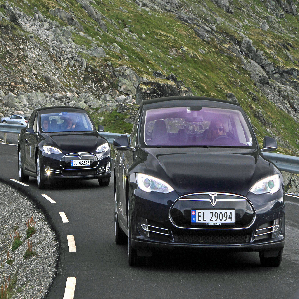

In [8]:
img

In [9]:
model = Xception(weights='imagenet')

In [10]:
preds = model.predict(img_scaled)

In [11]:
decode_predictions(preds, top=3)[0]

[('n03100240', 'convertible', 0.32023576),
 ('n04285008', 'sports_car', 0.16641538),
 ('n03459775', 'grille', 0.08980309)]

## Exercise 2

Choose another pre-trained model from the ones provided at https://keras.io/applications/ and use it to to predict the same image. Do the predictions match?

In [12]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications.vgg16 import decode_predictions

In [13]:
model = VGG16(weights='imagenet')

In [14]:
img, img_tensor = load_image_from_url(
    img_url, target_size=(224, 224))

In [15]:
img_scaled = preprocess_input(np.copy(img_tensor))

In [16]:
preds = model.predict(img_scaled)

In [17]:
decode_predictions(preds, top=3)[0]

[('n03594945', 'jeep', 0.19831586),
 ('n03770679', 'minivan', 0.15666518),
 ('n03100240', 'convertible', 0.111178935)]

## Exercise 3

The [Keras documentation](https://keras.io/applications/) shows how to fine-tune the Inception V3 model by unfreezing some of the convolutional layers. Try reproducing the results of the documentation on our dataset using the Xception model and unfreezing some of the top convolutional layers.

In [18]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.optimizers import SGD

In [19]:
img_size = 299

In [20]:
base_model = Xception(include_top=False, weights='imagenet',
                      input_shape=(img_size, img_size, 3),
                      pooling='avg')

In [21]:
x = base_model.output
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(3, activation='softmax')(x)

In [22]:
model = Model(inputs=base_model.input,
              outputs=predictions)

In [23]:
for layer in base_model.layers:
    layer.trainable = False

In [24]:
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [25]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=5,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

In [26]:
batch_size = 32

In [27]:
train_path = '../data/sports/train/'

In [28]:
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(img_size, img_size),
    batch_size=batch_size)

Found 2100 images belonging to 3 classes.


In [29]:
model.fit_generator(
    train_generator,
    steps_per_epoch=65,
    epochs=1)

65/65 [==============================] - 48s 743ms/step - loss: 0.5498 - accuracy: 0.7882


In [30]:
for i, layer in enumerate(base_model.layers):
    print(i, layer.name)

0 input_3
1 block1_conv1
2 block1_conv1_bn
3 block1_conv1_act
4 block1_conv2
5 block1_conv2_bn
6 block1_conv2_act
7 block2_sepconv1
8 block2_sepconv1_bn
9 block2_sepconv2_act
10 block2_sepconv2
11 block2_sepconv2_bn
12 conv2d_4
13 block2_pool
14 batch_normalization_v1_4
15 add_12
16 block3_sepconv1_act
17 block3_sepconv1
18 block3_sepconv1_bn
19 block3_sepconv2_act
20 block3_sepconv2
21 block3_sepconv2_bn
22 conv2d_5
23 block3_pool
24 batch_normalization_v1_5
25 add_13
26 block4_sepconv1_act
27 block4_sepconv1
28 block4_sepconv1_bn
29 block4_sepconv2_act
30 block4_sepconv2
31 block4_sepconv2_bn
32 conv2d_6
33 block4_pool
34 batch_normalization_v1_6
35 add_14
36 block5_sepconv1_act
37 block5_sepconv1
38 block5_sepconv1_bn
39 block5_sepconv2_act
40 block5_sepconv2
41 block5_sepconv2_bn
42 block5_sepconv3_act
43 block5_sepconv3
44 block5_sepconv3_bn
45 add_15
46 block6_sepconv1_act
47 block6_sepconv1
48 block6_sepconv1_bn
49 block6_sepconv2_act
50 block6_sepconv2
51 block6_sepconv2_bn
52 

In [31]:
# we chose to train the top 2 separable convolution
# blocks, i.e. we will freeze the first 126 layers
# and unfreeze the rest:

split_layer = 126

for layer in model.layers[:split_layer]:
    layer.trainable = False
for layer in model.layers[split_layer:]:
    layer.trainable = True

In [32]:
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [33]:
model.fit_generator(
    train_generator,
    steps_per_epoch=65,
    epochs=1);

65/65 [==============================] - 50s 769ms/step - loss: 0.3165 - accuracy: 0.8656
